In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#!pip install --upgrade nltk

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
import nltk
#from nltk.translate.meteor_score import meteor_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:

### All file names need to be configured in entire notebook

# flickr_token_filename = "/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt"
# train_images_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
# images = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'
# train_images_file = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
# test_images_file = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
# encoded_train_images_pkl_file = "/content/drive/My Drive/encoded_train_images1.pkl"
# encoded_test_images_pkl_file = "/content/drive/My Drive/encoded_test_images1.pkl"
# glove_dir = '/content/drive/My Drive/Flickr8k_text/'
# models_repo_path = '/content/drive/My Drive/model_'
# #test_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'

In [0]:
## Update only root_dir to maintain easy

root_dir = "/content/drive/My Drive/data_science/capstone_project/"


flickr_token_filename = root_dir+'Flickr8k/Flickr8k_text/Flickr8k.token.txt'
train_images_filename = root_dir+'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
images = root_dir+'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
train_images_file = root_dir+'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_file = root_dir+'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
encoded_train_images_pkl_file = root_dir+'encoded_train_images.pkl'
encoded_test_images_pkl_file = root_dir+'encoded_test_images.pkl'
glove_dir = root_dir+'Flickr8k/glove.6B.200d/'
models_repo_path = root_dir+'model_'

In [5]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load descriptions
doc = load_doc(flickr_token_filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [7]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [11]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [13]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [15]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
train = load_set(train_images_filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images

# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [17]:
img[:10]

['/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/380527679_574749123d.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/380515798_c2abbf46b0.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/381976882_0063d16d88.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/382090166_be2c2c63e1.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/382151094_c7376cf22b.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/384465370_9918873f9a.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/385835044_4aa11f6990.jpg',
 '/content/drive/My Drive/data_science/capstone_project/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/382701159_f

In [0]:
# Below file conatains the names of images to be used in train data

# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data

# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [20]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [22]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [23]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [25]:
model.layers[-2]

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [0]:
# Save the bottleneck train features to disk
with open(encoded_train_images_pkl_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 571.5337464809418


In [0]:
# Save the bottleneck test features to disk
with open(encoded_test_images_pkl_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open(encoded_train_images_pkl_file, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [47]:
test_features = encoding_test = load(open(encoded_test_images_pkl_file, "rb"))
print('Photos: train=%d' % len(test_features))

Photos: train=1000


In [29]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [30]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [32]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [33]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [35]:
# Load Glove vectors

embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(1652, 200)

In [38]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [40]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

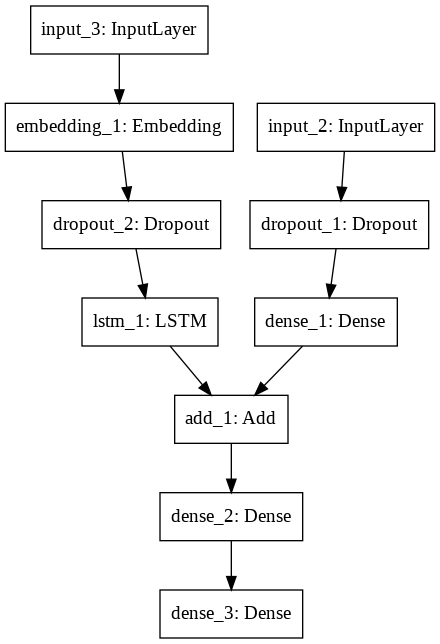

In [43]:
plot_model(model, to_file='model.png')

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
model_epoch_run = 'v1_'
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(models_repo_path + model_epoch_run + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1089s 545ms/step - loss: 4.1390
Epoch 1/1
2000/2000 [==============================] - 976s 488ms/step - loss: 3.4265
Epoch 1/1
2000/2000 [==============================] - 960s 480ms/step - loss: 3.2051
Epoch 1/1
2000/2000 [==============================] - 956s 478ms/step - loss: 3.0706
Epoch 1/1
2000/2000 [==============================] - 1026s 513ms/step - loss: 2.9742
Epoch 1/1
2000/2000 [==============================] - 1055s 528ms/step - loss: 2.9023
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.8432
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.7977
Epoch 1/1
2000/2000 [==============================] - 957s 479ms/step - loss: 2.7563
Epoch 1/1
2000/2000 [==============================] - 957s 478ms/step - loss: 2.7213


In [0]:
with open(encoded_test_images_pkl_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
model.load_weights(models_repo_path+'9.h5')

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

106490881_5a2dd9b7bd.jpg


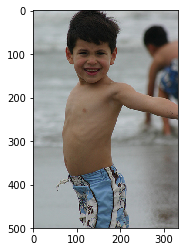

Greedy:  young boy in swim trunks is jumping into the water
Actual Captions:-
boy in his blue swim shorts at the beach
boy smiles for the camera at beach
young boy in swimming trunks is walking with his arms outstretched on the beach
children playing on the beach
the boy is playing on the shore of an ocean


In [48]:
z=1

pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
cand = greedySearch(image).split()
print("Greedy: ",greedySearch(image))


test = load_set(test_images_file)
test_descr = load_clean_descriptions('descriptions.txt', test)
print("Actual Captions:-")
reference = []
for descr in test_descr[pic.split('.')[0]]:
  reference.append(descr.replace('startseq ','').replace(' endseq','').split())
  print(descr.replace('startseq ','').replace(' endseq',''))

In [49]:
cand

['young',
 'boy',
 'in',
 'swim',
 'trunks',
 'is',
 'jumping',
 'into',
 'the',
 'water']

In [50]:

print("bleu score cumulative default ",sentence_bleu(reference,cand))
print("bleu score cumulative weighted gram ",sentence_bleu(reference,cand,weights=(0.4,0.3,0.2,0.1)))
print("Gleu score ", sentence_gleu(reference,cand))

bleu score cumulative default  0.4132584091896901
bleu score cumulative weighted gram  0.4114194717148079
Gleu score  0.2


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
def get_candidate(pic):
  image = encoding_test[pic].reshape((1,2048))
  candidate = greedySearch(image)
  return candidate



def get_references(pic):
  references = []
  for descr in test_descr[pic.split('.')[0]]:
      references.append(descr.replace('startseq ','').replace(' endseq','').split())
  return references

In [0]:
def get_bleu_gleu_score(references, candidate, metric='bleu', weights=(0.25,0.25,0.25,0.25)):
  if metric == 'bleu':
    #print(sentence_bleu(references,candidate,weights))
    return sentence_bleu(references,candidate,weights)
  if metric == 'gleu':
    #print(sentence_gleu(references,candidate))
    return sentence_gleu(references,candidate)

In [0]:

def get_avg_bleu_gleu_scores(pictures):
  total_bleu_default = 0.0
  total_bleu_custom = 0.0
  total_gleu = 0.0
  total_bleu_unigram = 0.0
  total_bleu_bigram = 0.0
  
  for pic in pictures[:10]:
    candidate = get_candidate(pic)
    candidate = candidate.split()
    references = get_references(pic)
    #print(references, candidate)
    total_bleu_unigram += get_bleu_gleu_score(references, candidate, 'bleu', (1,0,0,0))
    total_bleu_bigram += get_bleu_gleu_score(references, candidate, 'bleu',(0,1,0,0))
    total_bleu_default += get_bleu_gleu_score(references, candidate, 'bleu')
    total_bleu_custom += get_bleu_gleu_score(references, candidate,'bleu',(0.4,0.3,0.2,0.1))
    total_gleu += get_bleu_gleu_score(references,candidate,'gleu')
  return(total_bleu_unigram/len(pictures), total_bleu_bigram/len(pictures), total_bleu_default/len(pictures),total_bleu_custom/len(pictures),total_gleu/len(pictures))

In [55]:
### Get avg BLUE and GLUE scores for test images

pictures = list(encoding_test.keys())


(unigram_bleu_scr, bigram_bleu_scr, default_bleu_scr,custom_bleu_scr,gleu_scr)=get_avg_bleu_gleu_scores(pictures[:10])
print("Unigram bleu score: ",unigram_bleu_scr)
print("Bigram bleu score: ",bigram_bleu_scr)
print("Default cumulative bleu score: ",default_bleu_scr)
print("Custom cumulative bleu score: ",custom_bleu_scr)
print("Default gleu score: ",gleu_scr)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Unigram bleu score:  0.498467659907603
Bigram bleu score:  0.437642168972046
Default cumulative bleu score:  0.5605471324042985
Custom cumulative bleu score:  0.4932469195222966
Default gleu score:  0.19937609543780144


In [0]:
def get_avg_meteor_scores(pictures):
    total = 0
    avg_meteor_score = 0
    for pic in pictures:
        candidate = get_candidate(pic)
        references = get_references(pic)
        references = [' '.join(words_list) for words_list in references]
        #print(candidate, references)
        cur_m_score = meteor_score(references,candidate)
        #print(cur_m_score)
        total += cur_m_score
    #print(total)
    avg_meteor_score = total / len(pictures)
    return avg_meteor_score

In [0]:
#pictures = list(encoding_test.keys())
#avg_meteor_score = get_avg_meteor_scores(pictures[:10])
#print(avg_meteor_score)